# Project Introduction - Customer Segmentation (Part 2-3)
The goal of this project is to analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population with the aim of understanding which segment of the population the company should aim for in its next mail campaign. 

The project is divided into __three main parts__:
1. The first part will be decicated to the data preparation: This data is high-dimensional and has a high degree of missing values, therefore it is important to understand and clean the data.
2. In this section the customers will be segmented using a __unsupervised learning approach__ and using the customer's data against the general population's data. Not only is the goal to understand which groups of customers are more interesting for the campaign but also to select the most important features.
3. Using the information gained a __supervised learning algorithm__ will be used for a classification task to predict which recipients are most likely to become a customer for the mail-order company.

__Note__: This notebook handles part 2 and 3. The first part of the data cleaning process can be found in this notebook [here](https://github.com/bruno-f7s/portfolio/blob/main/arvarto-customer-segmentation/01-data-cleaning.ipynb).

In [5]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# magic word for producing visualizations in notebook
%matplotlib inline

# configurations
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.set_option('display.max_colwidth', None)

# PART 1: Customer Segmentation (Unsupervised Learning)
In this section we will try to understand which parts of the customers data are overrepresented or underrepresented in the population dataset with the goal of identifying the types of customers the company should target. This will be done by clustering both datasets and see how the distribution of the clusters looks like. Since we have more than 350 columns, it is a good idea to reduce the complexity of the problem to avoid redundancy and overfitting issues.

The approach looks like this:
1.	Reduce the dimensionality using PCA to a certain n number of components that explain at least __90%__ of the variance.
2.	Find the top 20 features which have the most impact on the total components, so we can use them to understand customer segments.
3.	Find a k number of clusters for the n components of the population data using the elbow method and use the ideal k to cluster the customer dataset.
4.	Compare the distribution of the clusters for the population with the customers’ dataset and see which ones are overrepresented or underrepresented.
5.	Make a centroid analysis of the clusters using for top 20 features to understand the types of customers the company should target or avoid. 


In [218]:
# Load the cleaned data for the customer segmentation part
population_df = pd.read_csv('data\\Cleaned_Udacity_AZDIAS_052018.csv', sep=';', index_col=[0])
customers_df = pd.read_csv('data\\Cleaned_Udacity_CUSTOMERS_052018.csv', sep=';', index_col=[0])

# Load the attributes df
attributes_df = pd.read_excel('data-dictionary\\DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4], skiprows=1)
attributes_df = attributes_df.fillna(method="ffill")
attributes_nms = list(attributes_df["Attribute"].unique())

In [219]:
# find columns that are not present in the data dictionary
cols_not_present = [col for col in population_df.columns if col not in attributes_nms]
print(cols_not_present)

['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_REST', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'DSL_FLAG', 'FIRMENDICHTE', 'GEMEINDETYP',

In [220]:
# Remove the D19_ columns from the list as they are present with another name
cols_not_present = [col for col in cols_not_present if "D19_" not in col]

# Remove the last 11 colums which were created in the cleaning process
cols_not_present = cols_not_present[:-11]

# Add some of the D19_ which are not available, even with a different name
cols_not_present += ["D19_TELKO_ONLINE_QUOTE_12", "D19_VERSI_ONLINE_QUOTE_12","D19_VERSI_ONLINE_DATUM"]

print(cols_not_present)

['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'DSL_FLAG', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_DATUM']


In [221]:
# Drop the columns not present in the data dictionary as they are impossible to analyse their meaning
population_df = population_df.drop(cols_not_present, axis=1)
customers_df = customers_df.drop(cols_not_present, axis=1)

In [222]:
population_df.shape

(791979, 312)

## 1.1 Dimensionality Reduction
- We will use the population dataset to understand which number of components should be chosen for the threshold of 85% variance explained. Then we will also see which number clusters are a good fit for this data. 
- To test for robustness, we will also conduct the same analysis with 3 other subsets of the data and see if the results are similar.

#### Population dataset

In [252]:
def plot_pca(df, df_name, threshhold):
    """
    This function plots the cumulative explained variance using PCA for a particular threshold of explained variance. 
    It takes in as arguments a dataset, the name of the dataset and a threshhold to find the number of components for that explained variance.

    """
    # Step 1: Scale the data
    sc = StandardScaler()
    scaled_df = sc.fit_transform(df)
    
    # Step 2: Fit a standard PCA to find the n components
    pca = PCA(random_state=101)
    pca_result = pca.fit_transform(scaled_df)

    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    n_components_for_threshhold = np.where(cum_explained_variance >= threshhold)[0][0]
    
    # Step 3 - Plot the Cumulative Explained Variances
    plt.figure(figsize=(16,6))

    plt.subplot(1, 2, 2)
    plt.plot(range(len(explained_variance)), cum_explained_variance)
    plt.ylabel('Cumulative explained variance ratio')
    plt.xlabel('Number of components')
    plt.title(f'Cumulative Explained Variance Plot for the {df_name}')
    plt.axhline(y=threshhold, color='grey', linestyle='--', label=f'Threshold at {threshhold}') 

    plt.annotate(text = f"{n_components_for_threshhold} components explain\n{round(threshhold*100)}% of the variance.",
                 xy = (n_components_for_threshhold, threshhold),
                 xytext = (n_components_for_threshhold, threshhold-0.1),
                 arrowprops=dict(arrowstyle='->'))

    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show(); 

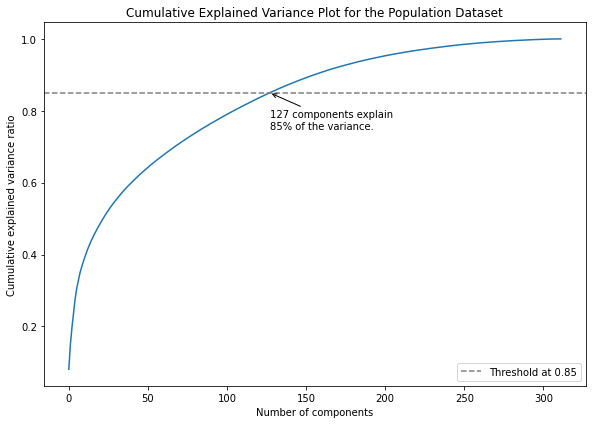

In [253]:
# Plot the PCA for the population dataset for a threshold of 85% of variance explained
plot_pca(population_df, "Population Dataset", 0.85)

__Observation__: We can see that for the whole population dataset __127 components__ would explain 90% of the variance. To be surer that this number is robust and not just due to correlated features, we can plot the same curve for different subsets of the dataset and see if the results keep consistent.

We can create 3 further random subsets plot them together with the population dataset.

In [225]:
# create subsets of the population dataset
dataset_names = ["Population Dataset", "Subset 1 of the Population Dataset", "Subset 2 of the Population Dataset", "Subset 3 of the Population Dataset"]

subset1_population_df = population_df.sample(n = round(len(population_df) * 0.25), random_state=1)
subset2_population_df = population_df.sample(n = round(len(population_df) * 0.4), random_state=51)
subset3_population_df = population_df.sample(n = round(len(population_df) * 0.3), random_state=101)

datasets = [population_df, subset1_population_df, subset2_population_df, subset3_population_df]

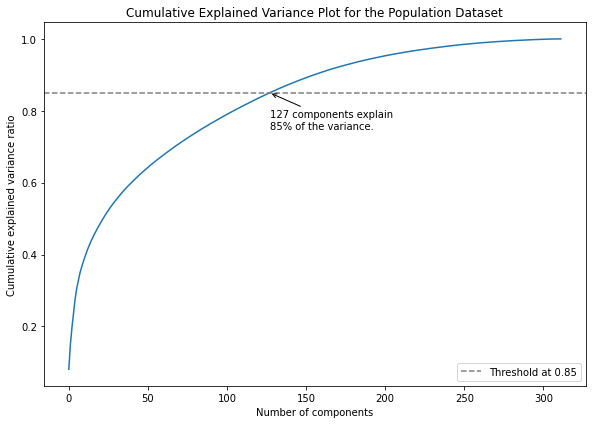

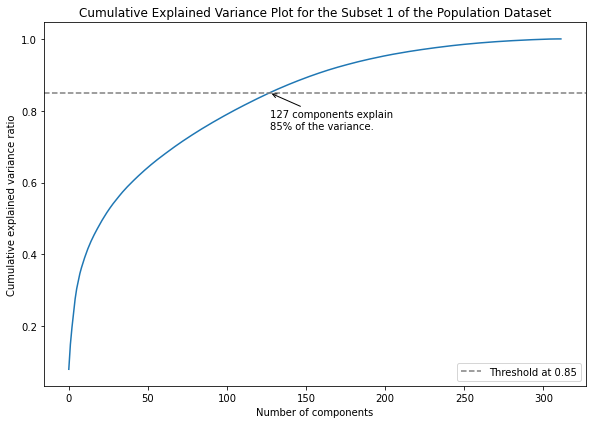

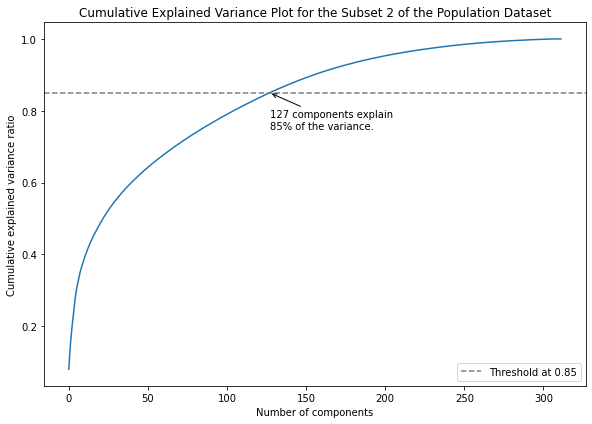

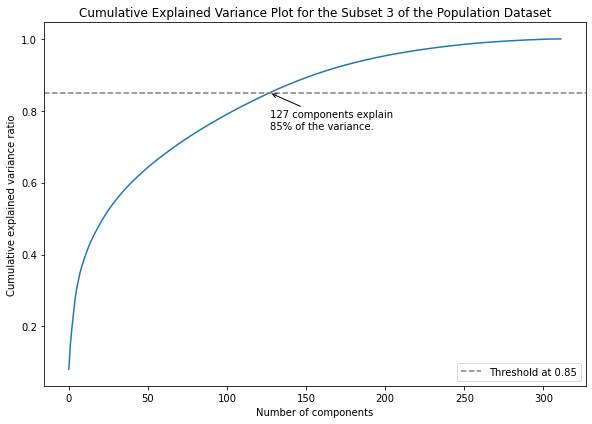

In [254]:
# Plot the PCA of the 4 datasets
for data, name in zip(datasets, dataset_names):
    plot_pca(data, name, 0.85)

__Analysis__: Based on the graphics above we can determine that the initial value of __127 components__ is indeed robust for explaining ca. 85% of the variance of the data. This means that we can reduce the dimensionality of the dataset almost by half and still maintain the general explainability.

__Observation__: The next step now would be to understand which features are being more important to explain variance of the data. One way to do this would be to look at the first principal component and then the second, which is something that we see a lot in literature. However, these components in this dataset are weak in terms of explaining the variance so if we just focus on those, we will potentially lose some information.

There are some ways we can deal with this issue:
1. We can look the the feature importance for all components at once by squaring the PCA components (loadings) and summing along the columns for all the components.
2. We can find features that consistently show up as influential across multiple principal components by looping through the components where the curve of the explainable variance is steeper (i. e. until ca. 0.6) and adding a count for each column that appears on the top 20 most influential columns. At the end we can select again the top 20 features that appeared most for all components.
    
We can try both and compare the results.

In [255]:
# Scale the data
sc = StandardScaler()
scaled_population_df = sc.fit_transform(population_df)

# Fit the PCA with 127 onto the population dataset
pca = PCA(n_components=127, random_state=101)
pca_population = pca.fit_transform(scaled_population_df)

explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)

__Find top 20 most influencial features - Approach 1__

In [258]:
# Compute the Importance (or Influence) of Each Feature:
feature_influence = np.sum(pca.components_**2, axis=0)

# Rank and Select the Top 20 Features
top_20_indices = feature_influence.argsort()[-20:][::-1]

# Get the Names of the Top 20 Features
top_20_features_approach_1 = [list(population_df.columns)[i] for i in top_20_indices]

print(top_20_features_approach_1)

['D19_BANKEN_LOKAL', 'D19_TIERARTIKEL', 'CAMEO_DEU_2015_2F', 'D19_ENERGIE', 'D19_DIGIT_SERV', 'D19_TELKO_ONLINE_DATUM', 'GEBAEUDETYP', 'D19_LEBENSMITTEL', 'D19_HANDWERK', 'GFK_URLAUBERTYP', 'D19_VERSI_OFFLINE_DATUM', 'D19_BANKEN_REST', 'CAMEO_DEU_2015_2X', 'D19_BEKLEIDUNG_REST', 'D19_BEKLEIDUNG_GEH', 'D19_NAHRUNGSERGAENZUNG', 'CAMEO_DEU_2015_2E', 'D19_GARTEN', 'D19_FREIZEIT', 'D19_SOZIALES']


__Find top 20 most influencial features - Approach 2__

In [284]:
# Instantiate an array of zeros for the number of features 
feature_counts = np.zeros(len(population_df.columns))

# For each component of the first 50 components and find the top 20 most influential features while adding 1 to the feature counts
for component in pca.components_[:50]:
    top_indices = np.abs(component).argsort()[-20:][::-1]
    feature_counts[top_indices] += 1

# Rank and select the final Top 20 Features    
top_20_final_indices = feature_counts.argsort()[-20:][::-1]

# Get the Names of the Top 20 Features
top_20_features_approach_2 = [list(population_df.columns)[i] for i in top_20_final_indices]

print(top_20_features_approach_2)

['KBA13_FAB_SONSTIGE', 'LP_FAMILIE_FEIN', 'KBA13_HERST_SONST', 'CAMEO_DEU_2015_2A', 'KBA13_HERST_EUROPA', 'KBA05_ANTG4', 'ANZ_PERSONEN', 'CAMEO_DEU_2015_2B', 'KBA05_ANTG2', 'FINANZTYP', 'PLZ8_HHZ', 'KBA13_KW_70', 'KBA13_KW_120', 'GEBURTSJAHR_RTV23', 'KBA13_KMH_140_210', 'KBA13_KW_60', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'LP_LEBENSPHASE_FEIN', 'KBA13_CCM_2501']


__Analysis:__ We can see that the two approaches lead to different features that are important and deciding which one is the best would be better with a domain expert. Since this is something not available, I decided to go for the second approach because we are only considering the features which contribute the most for a higher variability in the explained variance. If we would include all the components in this analysis, it is likely that when the explained variance does not change that much (i. e. when it is greater than ca. 0.6), the features which contribute the most for these small changes will repeat themselves and therefore appear with more counts. We are interested in the top features which influence the explained variability the most.

Based on this analysis these are the features to be considered for the customer segmentation analysis when we cluster the data sorted by importance:
- `ANZ_PERSONEN`: number of adult persons in the household.
- `D19_TELKO_ANZ_12`: transaction activity TELCO in the last 12 months.
- `D19_TELKO_ANZ_24`: transaction activity TELCO in the last 24 months.
- `D19_VERSI_ANZ_24`: transaction activity INSURANCE in the last 24 months.
- `KBA05_ANTG2`: number of 3-5 family houses in the cell.
- `KBA05_ANTG4`: number of >10 family houses in the cell.
- `KBA13_ANZAHL_PKW`: number of cars in the PLZ8.
- `KBA13_BJ_2004`: share of cars built before 2004 within the PLZ8.
- `KBA13_CCM_1400`: share of cars with 1200ccm to 1399ccm within the PLZ8.
- `KBA13_FAB_SONSTIGE`: 
- `KBA13_HALTER_45`: share of car owners between 41 and 45 within the PLZ8.
- `KBA13_HERST_ASIEN`: 
- `KBA13_HERST_EUROPA`: 
- `KBA13_HERST_SONST`: 
- `KBA13_KMH_140_210`: 
- `KBA13_KRSSEG_VAN`: 
- `KBA13_KW_60`: 
- `KBA13_VORB_1`: 
- `LP_FAMILIE_FEIN`: 
- `PLZ8_HHZ`: 


- `KBA13_FAB_SONSTIGE`: share of other Manufacturers within the PLZ8.
- `LP_FAMILIE_FEIN`: familytyp fine.
- `KBA13_HERST_SONST`: share of other cars within the PLZ8.
- `CAMEO_DEU_2015_2A`: 
- `KBA13_HERST_EUROPA`: 
- `KBA05_ANTG4`: 
- `ANZ_PERSONEN`: 
- `CAMEO_DEU_2015_2B`: 
- `KBA05_ANTG2`: 
- `FINANZTYP`: 
- `PLZ8_HHZ`: 
- `KBA13_KW_70`: 
- `KBA13_KW_120`: 
- `GEBURTSJAHR_RTV23`: 
- `KBA13_KMH_140_210`: 
- `KBA13_KW_60`: 
- `D19_TELKO_ANZ_12`: 
- `D19_TELKO_ANZ_24`: 
- `LP_LEBENSPHASE_FEIN`: 
- `KBA13_CCM_2501`: 

In [176]:
top_20_features_approach_2

['ANZ_PERSONEN',
 'ANZ_TITEL',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_ONLINE_QUOTE_12',
 'FINANZTYP',
 'KBA05_ANTG2',
 'KBA05_ANTG4',
 'KBA13_BJ_2004',
 'KBA13_FAB_SONSTIGE',
 'KBA13_HERST_EUROPA',
 'KBA13_HERST_SONST',
 'KBA13_KRSSEG_VAN',
 'LP_FAMILIE_FEIN',
 'LP_LEBENSPHASE_FEIN',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'TITEL_KZ']

# PART 2: Customer Prediction (Supervised Learning)

In [ ]:
# Load data for the customer prediction part
train_df = pd.read_csv('data\\Cleaned_Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)
test_df = pd.read_csv('data\\Cleaned_Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)